# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

2021-12-30 00:14:39.833305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-30 00:14:39.833325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.8.0-rc0'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0002 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


/usr/lib/python3.10/site-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [4]:
from tensorflow.keras import Sequential
model = Sequential()
base = tf.keras.applications.InceptionV3(    input_shape=None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000
)

freeze = 13

for layer in (base.layers[:freeze]):
  layer.trainable =  False


model.add(base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(4))
model.build(input_shape=(None, 224,224,3))
model.summary()



2021-12-30 00:14:49.091236: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-30 00:14:49.091324: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: danASUS
2021-12-30 00:14:49.091349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: danASUS
2021-12-30 00:14:49.091576: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.46.0
2021-12-30 00:14:49.091652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.46.0
2021-12-30 00:14:49.091669: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.46.0
2021-12-30 00:14:49.092215: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

96124928/96112376 [==============================] - 24s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1000)              23851784  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 24,141,452
Trainable params: 24,073,180
Non-trainable params: 68,272
_______________________________________

#### [5 points] Train Model

In [5]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

model.build(input_shape=(None,224,224,3))
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_batches, epochs = 100, validation_data=valid_batches)

22
6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1000)              23851784  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 24,141,452
Trainable params: 24,073,180
Non-trainable params: 68,272
_________________________________________________________________


/usr/lib/python3.10/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/lib/python3.10/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


2021-12-30 00:15:35.056418: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30415360 exceeds 10% of free system memory.
2021-12-30 00:15:35.116123: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20766720 exceeds 10% of free system memory.
2021-12-30 00:15:35.178999: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20766720 exceeds 10% of free system memory.
2021-12-30 00:15:36.389199: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24480000 exceeds 10% of free system memory.
2021-12-30 00:15:36.390503: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24480000 exceeds 10% of free system memory.


22/22 [==============================] - 51s 2s/step - loss: 1.3848 - accuracy: 0.2963 - val_loss: 1.3887 - val_accuracy: 0.1667
Epoch 2/100
22/22 [==============================] - 42s 2s/step - loss: 1.3698 - accuracy: 0.4444 - val_loss: 1.3722 - val_accuracy: 0.2778
Epoch 3/100
22/22 [==============================] - 42s 2s/step - loss: 1.3462 - accuracy: 0.4676 - val_loss: 1.3210 - val_accuracy: 0.4815
Epoch 4/100
22/22 [==============================] - 42s 2s/step - loss: 1.2935 - accuracy: 0.5231 - val_loss: 1.2700 - val_accuracy: 0.5000
Epoch 5/100
22/22 [==============================] - 44s 2s/step - loss: 1.2480 - accuracy: 0.5185 - val_loss: 1.2780 - val_accuracy: 0.4815
Epoch 6/100
22/22 [==============================] - 44s 2s/step - loss: 1.2508 - accuracy: 0.5000 - val_loss: 1.2586 - val_accuracy: 0.4815
Epoch 7/100
22/22 [==============================] - 45s 2s/step - loss: 1.1922 - accuracy: 0.5417 - val_loss: 1.4401 - val_accuracy: 0.3148
Epoch 8/100
22/22 [======

#### [5 points] Plot Accuracy and Loss During Training

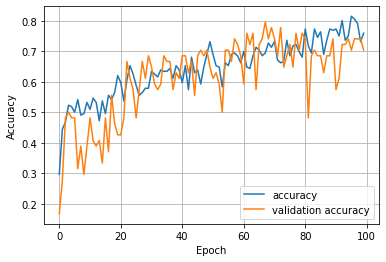

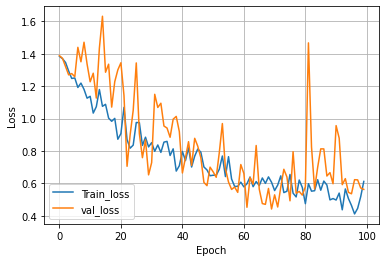

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.grid()
plt.show()

#### Testing Model

In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
 1/36 [..............................] - ETA: 4s - loss: 0.4836 - accuracy: 1.0000

/tmp/ipykernel_46048/463003407.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),


36/36 [==============================] - 3s 88ms/step - loss: 0.9430 - accuracy: 0.5833
Test loss: 0.9430484771728516
Test accuracy: 0.5833333134651184


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.


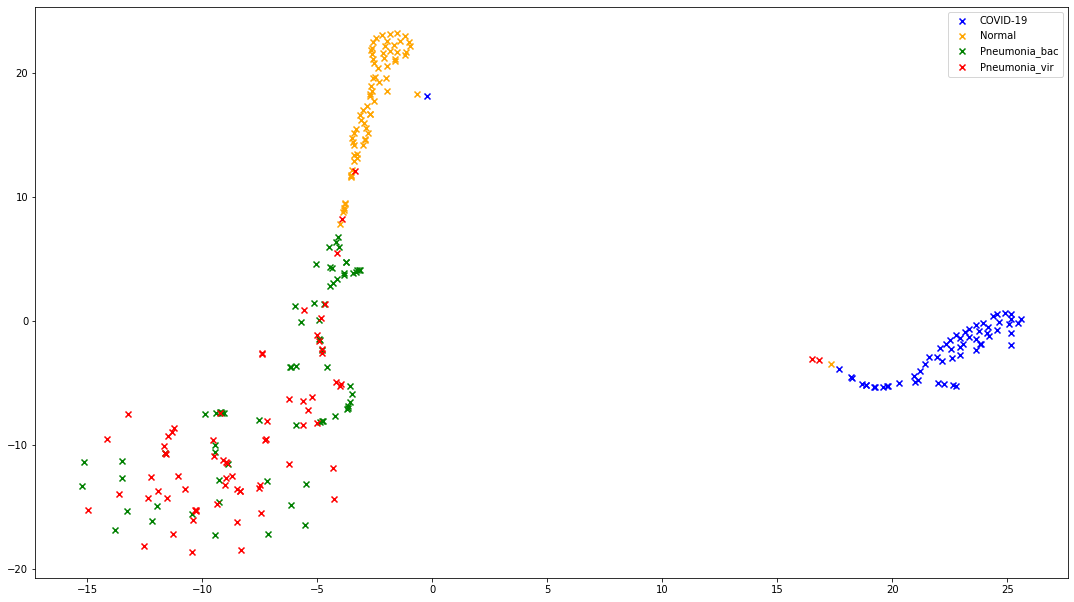

In [10]:
from sklearn.manifold import TSNE
import matplotlib
from matplotlib import figure

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_1').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")

classes = []
for i in range(len(tsne_eval_generator)):
    pix, class_val = tsne_eval_generator[i]
    for val in range(len(class_val[0])):
        if class_val[0][val] == 1:
            classes.append(val)
out = intermediate_layer_model.predict(tsne_eval_generator)
reduced = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(out)
x = reduced[ :,0]
y = reduced[ :,1]
covid_x = []
covid_y = []
normal_x = []
normal_y = []
pneumonia_bac_x = []
pneumonia_bac_y = []
pneumonia_vir_x = []
pneumonia_vir_y = []
for value in range(len(x)):
    if classes[value] == 0:
        covid_x.append(x[value])
        covid_y.append(y[value])
    elif classes[value] == 1:
        normal_x.append(x[value])
        normal_y.append(y[value])
    elif classes[value] == 2:
        pneumonia_bac_x.append(x[value])
        pneumonia_bac_y.append(y[value])
    else:
        pneumonia_vir_x.append(x[value])
        pneumonia_vir_y.append(y[value])
plt.scatter(covid_x, covid_y, c='blue', label="COVID-19", marker = 'x')
plt.scatter(normal_x, normal_y, c='orange', label="Normal", marker = 'x')
plt.scatter(pneumonia_bac_x, pneumonia_bac_y, c='green', label="Pneumonia_bac", marker = 'x')
plt.scatter(pneumonia_vir_x, pneumonia_vir_y, c='red', label="Pneumonia_vir", marker = 'x')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.legend()
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->